# Step 1. Getting the SEED dataset

## 1.1 load the matlab format files and take a look

In [ ]:
import mne
from scipy import io
import os
import numpy as np

In [ ]:
folderpath = "./Preprocessed_EEG"

In [2]:
raw_1_1 = io.loadmat('./Preprocessed_EEG/1_20131027.mat')
raw_1_2 = io.loadmat('./Preprocessed_EEG/1_20131030.mat')
raw_1_3 = io.loadmat('./Preprocessed_EEG/1_20131107.mat')
# raw_2_1 = scipy.io.loadmat('./Preprocessed_EEG/2_20140404.mat')
label = io.loadmat('./Preprocessed_EEG/label.mat')

In [3]:
raw_1_1.keys(), raw_1_2.keys(), raw_1_3.keys(), label.keys()

(dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15']),
 dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15']),
 dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15']),
 dict_keys(['__header__', '__version__', '__globals__', 'label']))

In [4]:
raw_1_1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15'])

In [5]:
raw_1_1['djc_eeg2'].shape, raw_1_2['djc_eeg2'].shape, raw_1_1['djc_eeg10'].shape, raw_1_3['djc_eeg10'].shape

((62, 46601), (62, 46601), (62, 47401), (62, 47401))

raw_1_1['djc_eeg1']:
- raw_1_1: the raw eeg data, the 1st subject(out of 15 subjects), the 1st experiments(out of 3 experiments)
- 'djc_eeg1': djc could possibly mean the name of the subject(which leaks the privacy XD), and 'eeg1' represents it is the 1st trial(out of 15 trials)
- 62: n_channels
- 47001: roughly 4 mins(240sec * 200 Hz sampling rate) the eeg signal during watching the movies

In [6]:
label['label'][0]

array([ 1,  0, -1, -1,  0,  1, -1,  0,  1,  1,  0, -1,  0,  1, -1],
      dtype=int16)

## 1.2 Create the torch dataset

### 1.2.1 cut compute windows

since a movie clip contains eeg signals of ~240 seconds with sf=200Hz, I decide to cut them into 4 sec windows

In [7]:
len_window = 200 * 4

raw_X = []
raw_y = []

prefix = 'djc_eeg'

# raw_1_1
for i in range(1, 16):
    data = raw_1_1[prefix + str(i)]
    # print(data.shape)
    n_windows = data.shape[1] // len_window
    # print(n_windows)
    reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
    raw_X.append(reshaped_X)
    raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))

# raw_1_2
for i in range(1, 16):
    data = raw_1_2[prefix + str(i)]
    # print(data.shape)
    n_windows = data.shape[1] // len_window
    # print(n_windows)
    reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
    raw_X.append(reshaped_X)
    raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))
    # print(reshaped_X.shape)   # print(reshaped_X.shape)

# raw_1_3
for i in range(1, 16):
    data = raw_1_3[prefix + str(i)]
    # print(data.shape)
    n_windows = data.shape[1] // len_window
    # print(n_windows)
    reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
    raw_X.append(reshaped_X)
    raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))
    # print(reshaped_X.shape)   # print(reshaped_X.shape)

In [8]:
concat_X = np.concatenate(raw_X, axis=2)
print(concat_X.shape)
concat_y = np.concatenate(raw_y)
print(concat_y.shape)

(62, 800, 2526)
(2526,)


### 1.2.2 Encode the labels

In [9]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [10]:
concat_y

array([ 1,  1,  1, ..., -1, -1, -1], dtype=int16)

In [11]:
le = LabelEncoder()
y = le.fit_transform(concat_y)
y = pd.get_dummies(y)
y

,0,1,2
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
2521,1,0,0
2522,1,0,0
2523,1,0,0
2524,1,0,0


one-hot encoding
- positive:  1 => [0, 0 ,1]
- neutral:   0 => [0, 1, 0]
- negative: -1 => [1, 0, 0]

In [12]:
y.shape, concat_X.shape

((2526, 3), (62, 800, 2526))

# Step 2. Create EEG-conformer model

In [51]:
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable 
from tqdm import tqdm
import matplotlib_inline

In [14]:
cuda_version = torch.version.cuda
cuda_version

'11.7'

In [58]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.device = torch.device("cuda")

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(self.device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(self.device) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
 
model=LSTM(
    num_classes=3,
    input_size=62,
    hidden_size=50,
    num_layers=1,
    seq_length=800,
)

# 打印模型结构
print(model)

LSTM(
  (lstm): LSTM(62, 50, batch_first=True)
  (fc_1): Linear(in_features=50, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)


In [57]:
device

device(type='cuda')

In [59]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('the model will be trained on: ', device)
    model.to(device)

the model will be trained on:  cuda


LSTM(
  (lstm): LSTM(62, 50, batch_first=True)
  (fc_1): Linear(in_features=50, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)

In [60]:
from torchsummaryX import summary
summary(model, torch.zeros(32, 800, 62).to(device))

       Kernel Shape   Output Shape  Params Mult-Adds
Layer                                               
0_lstm            -  [32, 800, 50]   22.8k     22.4k
1_relu            -       [32, 50]       -         -
2_fc_1    [50, 128]      [32, 128]  6.528k      6.4k
3_relu            -      [32, 128]       -         -
4_fc       [128, 3]        [32, 3]   387.0     384.0
------------------------------------------------------
                       Totals
Total params          29.715k
Trainable params      29.715k
Non-trainable params      0.0
Mult-Adds             29.184k


/home/pai/envs/fbc/lib/python3.7/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[32, 800, 50]",22800.0,22400.0
1_relu,-,"[32, 50]",NaN,NaN
2_fc_1,"[50, 128]","[32, 128]",6528.0,6400.0
3_relu,-,"[32, 128]",NaN,NaN
4_fc,"[128, 3]","[32, 3]",387.0,384.0


# Step 3. Training the model

## 3.1 prepare the train set / test set

In [15]:
concat_X.shape, y.shape

((62, 800, 2526), (2526, 3))

In [16]:
X = concat_X.transpose((2, 1, 0))
X.shape

(2526, 800, 62)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=777)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1768, 800, 62), (758, 800, 62), (1768, 3), (758, 3))

## 3.2 Training

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

x_train_tensor = torch.from_numpy(X_train).to(torch.float32).to(device)
y_train_tensor = torch.from_numpy(y_train.values).to(torch.float32).to(device)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

x_test_tensor = torch.from_numpy(X_test).to(torch.float32).to(device)
y_test_tensor = torch.from_numpy(y_test.values).to(torch.float32).to(device)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [62]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

In [63]:
def train(model, x_train, y_train, x_test, y_test, save_path='./model_LSTM/', n_epochs=100):
    """
    the training function.
    Attributes:
    - model: the instance of the network
    - save_path: the path to which the model state will be saved. None means w/o saving.

    Return: 
    the best model if save_path is not None, the last model otherwise
    """
    train_acc_list.clear()
    train_loss_list.clear()
    test_acc_list.clear()
    test_loss_list.clear()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('the model will be trained on: ', device)

    best_accuracy = 0.0
    
    for epoch in range(n_epochs):
        training_loss = 0.0
        testing_loss = 0.0
        correct = 0
        total = 0
        
        model.train()
        for inputs, labels in tqdm(train_loader):
            # print(inputs.shape, labels.shape)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print("lables.size", labels.shape)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            # print(outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, label = torch.max(labels, 1)
            # print(predicted.shape)
            total += labels.size(0)
            correct += (predicted == label).sum().item()
        
        train_loss = training_loss / len(train_loader)
        train_loss_list.append(train_loss)
        train_accuracy = correct / total
        train_acc_list.append(train_accuracy)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                testing_loss += loss.item()


                _, predicted = torch.max(outputs.data, 1)
                _, label = torch.max(labels, 1)
                total += labels.size(0)
                correct += (predicted == label).sum().item()
            
            test_loss = testing_loss / len(test_loader)
            test_loss_list.append(test_loss)
            test_accuracy = correct / total
            test_acc_list.append(test_accuracy)

            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                if save_path is not None:
                    torch.save(model.state_dict(), save_path + 'best_model.pth')
                    print("best_model found, best acc: ", best_accuracy)
        
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")
    
    if save_path is not None: 
        model.load_state_dict(torch.load(save_path + 'best_model.pth'))
    
    return model

In [64]:
best_model = train(model, X_train, X_test, y_train, y_test, n_epochs=100)

the model will be trained on:  cuda


100%|██████████| 56/56 [00:00<00:00, 90.50it/s] 


best_model found, best acc:  0.6860158311345647
Epoch 1/100 - Train Loss: 1.0059 - Train Accuracy: 0.5271 - Test Loss: 0.8728 - Test Accuracy: 0.6860


100%|██████████| 56/56 [00:00<00:00, 160.06it/s]


best_model found, best acc:  0.7810026385224275
Epoch 2/100 - Train Loss: 0.6672 - Train Accuracy: 0.7607 - Test Loss: 0.5233 - Test Accuracy: 0.7810


100%|██████████| 56/56 [00:00<00:00, 171.04it/s]


best_model found, best acc:  0.8364116094986808
Epoch 3/100 - Train Loss: 0.4211 - Train Accuracy: 0.8184 - Test Loss: 0.3723 - Test Accuracy: 0.8364


100%|██████████| 56/56 [00:00<00:00, 168.96it/s]


best_model found, best acc:  0.8482849604221636
Epoch 4/100 - Train Loss: 0.3347 - Train Accuracy: 0.8541 - Test Loss: 0.3238 - Test Accuracy: 0.8483


100%|██████████| 56/56 [00:00<00:00, 166.68it/s]


Epoch 5/100 - Train Loss: 0.3108 - Train Accuracy: 0.8507 - Test Loss: 0.3160 - Test Accuracy: 0.8377


100%|██████████| 56/56 [00:00<00:00, 166.13it/s]


Epoch 6/100 - Train Loss: 0.3223 - Train Accuracy: 0.8360 - Test Loss: 0.3305 - Test Accuracy: 0.8298


100%|██████████| 56/56 [00:00<00:00, 159.83it/s]


Epoch 7/100 - Train Loss: 0.2983 - Train Accuracy: 0.8558 - Test Loss: 0.2984 - Test Accuracy: 0.8470


100%|██████████| 56/56 [00:00<00:00, 170.33it/s]


best_model found, best acc:  0.8707124010554089
Epoch 8/100 - Train Loss: 0.2921 - Train Accuracy: 0.8563 - Test Loss: 0.2994 - Test Accuracy: 0.8707


100%|██████████| 56/56 [00:00<00:00, 169.26it/s]


best_model found, best acc:  0.8746701846965699
Epoch 9/100 - Train Loss: 0.3028 - Train Accuracy: 0.8507 - Test Loss: 0.2839 - Test Accuracy: 0.8747


100%|██████████| 56/56 [00:00<00:00, 157.63it/s]


Epoch 10/100 - Train Loss: 0.2890 - Train Accuracy: 0.8518 - Test Loss: 0.3024 - Test Accuracy: 0.8536


100%|██████████| 56/56 [00:00<00:00, 170.30it/s]


Epoch 11/100 - Train Loss: 0.2779 - Train Accuracy: 0.8592 - Test Loss: 0.2780 - Test Accuracy: 0.8654


100%|██████████| 56/56 [00:00<00:00, 166.26it/s]


Epoch 12/100 - Train Loss: 0.2686 - Train Accuracy: 0.8614 - Test Loss: 0.3187 - Test Accuracy: 0.8391


100%|██████████| 56/56 [00:00<00:00, 171.98it/s]


Epoch 13/100 - Train Loss: 0.2859 - Train Accuracy: 0.8541 - Test Loss: 0.2884 - Test Accuracy: 0.8456


100%|██████████| 56/56 [00:00<00:00, 171.06it/s]


Epoch 14/100 - Train Loss: 0.2720 - Train Accuracy: 0.8643 - Test Loss: 0.2620 - Test Accuracy: 0.8668


100%|██████████| 56/56 [00:00<00:00, 161.36it/s]


best_model found, best acc:  0.8773087071240105
Epoch 15/100 - Train Loss: 0.2572 - Train Accuracy: 0.8756 - Test Loss: 0.2543 - Test Accuracy: 0.8773


100%|██████████| 56/56 [00:00<00:00, 165.23it/s]


best_model found, best acc:  0.8918205804749341
Epoch 16/100 - Train Loss: 0.2518 - Train Accuracy: 0.8846 - Test Loss: 0.2353 - Test Accuracy: 0.8918


100%|██████████| 56/56 [00:00<00:00, 171.51it/s]


best_model found, best acc:  0.9129287598944591
Epoch 17/100 - Train Loss: 0.2267 - Train Accuracy: 0.9067 - Test Loss: 0.2184 - Test Accuracy: 0.9129


100%|██████████| 56/56 [00:00<00:00, 166.56it/s]


Epoch 18/100 - Train Loss: 0.2344 - Train Accuracy: 0.8971 - Test Loss: 0.2272 - Test Accuracy: 0.9011


100%|██████████| 56/56 [00:00<00:00, 172.08it/s]


best_model found, best acc:  0.9142480211081794
Epoch 19/100 - Train Loss: 0.2258 - Train Accuracy: 0.8954 - Test Loss: 0.2046 - Test Accuracy: 0.9142


100%|██████████| 56/56 [00:00<00:00, 170.13it/s]


Epoch 20/100 - Train Loss: 0.2118 - Train Accuracy: 0.9038 - Test Loss: 0.2243 - Test Accuracy: 0.8971


100%|██████████| 56/56 [00:00<00:00, 155.62it/s]


Epoch 21/100 - Train Loss: 0.2121 - Train Accuracy: 0.8999 - Test Loss: 0.2129 - Test Accuracy: 0.8958


100%|██████████| 56/56 [00:00<00:00, 162.96it/s]


best_model found, best acc:  0.9182058047493403
Epoch 22/100 - Train Loss: 0.1935 - Train Accuracy: 0.9118 - Test Loss: 0.1828 - Test Accuracy: 0.9182


100%|██████████| 56/56 [00:00<00:00, 165.62it/s]


best_model found, best acc:  0.9234828496042217
Epoch 23/100 - Train Loss: 0.2004 - Train Accuracy: 0.9095 - Test Loss: 0.1946 - Test Accuracy: 0.9235


100%|██████████| 56/56 [00:00<00:00, 167.30it/s]


Epoch 24/100 - Train Loss: 0.1847 - Train Accuracy: 0.9095 - Test Loss: 0.2034 - Test Accuracy: 0.8892


100%|██████████| 56/56 [00:00<00:00, 155.95it/s]


best_model found, best acc:  0.924802110817942
Epoch 25/100 - Train Loss: 0.1849 - Train Accuracy: 0.9078 - Test Loss: 0.1786 - Test Accuracy: 0.9248


100%|██████████| 56/56 [00:00<00:00, 158.27it/s]


Epoch 26/100 - Train Loss: 0.1717 - Train Accuracy: 0.9163 - Test Loss: 0.1719 - Test Accuracy: 0.9156


100%|██████████| 56/56 [00:00<00:00, 171.72it/s]


best_model found, best acc:  0.9261213720316622
Epoch 27/100 - Train Loss: 0.1621 - Train Accuracy: 0.9253 - Test Loss: 0.1591 - Test Accuracy: 0.9261


100%|██████████| 56/56 [00:00<00:00, 174.43it/s]


best_model found, best acc:  0.9327176781002638
Epoch 28/100 - Train Loss: 0.1472 - Train Accuracy: 0.9338 - Test Loss: 0.1448 - Test Accuracy: 0.9327


100%|██████████| 56/56 [00:00<00:00, 167.30it/s]


Epoch 29/100 - Train Loss: 0.1617 - Train Accuracy: 0.9299 - Test Loss: 0.1548 - Test Accuracy: 0.9274


100%|██████████| 56/56 [00:00<00:00, 172.47it/s]


Epoch 30/100 - Train Loss: 0.1640 - Train Accuracy: 0.9276 - Test Loss: 0.1627 - Test Accuracy: 0.9301


100%|██████████| 56/56 [00:00<00:00, 170.18it/s]


best_model found, best acc:  0.9406332453825857
Epoch 31/100 - Train Loss: 0.1464 - Train Accuracy: 0.9344 - Test Loss: 0.1415 - Test Accuracy: 0.9406


100%|██████████| 56/56 [00:00<00:00, 164.51it/s]


Epoch 32/100 - Train Loss: 0.1365 - Train Accuracy: 0.9383 - Test Loss: 0.1440 - Test Accuracy: 0.9301


100%|██████████| 56/56 [00:00<00:00, 171.81it/s]


Epoch 33/100 - Train Loss: 0.1489 - Train Accuracy: 0.9344 - Test Loss: 0.1514 - Test Accuracy: 0.9406


100%|██████████| 56/56 [00:00<00:00, 168.79it/s]


Epoch 34/100 - Train Loss: 0.1330 - Train Accuracy: 0.9417 - Test Loss: 0.1419 - Test Accuracy: 0.9380


100%|██████████| 56/56 [00:00<00:00, 170.01it/s]


best_model found, best acc:  0.9445910290237467
Epoch 35/100 - Train Loss: 0.1304 - Train Accuracy: 0.9434 - Test Loss: 0.1594 - Test Accuracy: 0.9446


100%|██████████| 56/56 [00:00<00:00, 164.86it/s]


Epoch 36/100 - Train Loss: 0.1462 - Train Accuracy: 0.9333 - Test Loss: 0.1366 - Test Accuracy: 0.9406


100%|██████████| 56/56 [00:00<00:00, 155.14it/s]


best_model found, best acc:  0.945910290237467
Epoch 37/100 - Train Loss: 0.1174 - Train Accuracy: 0.9508 - Test Loss: 0.1344 - Test Accuracy: 0.9459


100%|██████████| 56/56 [00:00<00:00, 164.35it/s]


best_model found, best acc:  0.9485488126649076
Epoch 38/100 - Train Loss: 0.1211 - Train Accuracy: 0.9463 - Test Loss: 0.1202 - Test Accuracy: 0.9485


100%|██████████| 56/56 [00:00<00:00, 166.15it/s]


best_model found, best acc:  0.9498680738786279
Epoch 39/100 - Train Loss: 0.1222 - Train Accuracy: 0.9497 - Test Loss: 0.1328 - Test Accuracy: 0.9499


100%|██████████| 56/56 [00:00<00:00, 166.64it/s]


Epoch 40/100 - Train Loss: 0.1233 - Train Accuracy: 0.9474 - Test Loss: 0.1357 - Test Accuracy: 0.9340


100%|██████████| 56/56 [00:00<00:00, 175.25it/s]


Epoch 41/100 - Train Loss: 0.1165 - Train Accuracy: 0.9451 - Test Loss: 0.1220 - Test Accuracy: 0.9433


100%|██████████| 56/56 [00:00<00:00, 158.83it/s]


Epoch 42/100 - Train Loss: 0.1199 - Train Accuracy: 0.9417 - Test Loss: 0.1415 - Test Accuracy: 0.9393


100%|██████████| 56/56 [00:00<00:00, 166.91it/s]


Epoch 43/100 - Train Loss: 0.1176 - Train Accuracy: 0.9440 - Test Loss: 0.1223 - Test Accuracy: 0.9393


100%|██████████| 56/56 [00:00<00:00, 168.19it/s]


best_model found, best acc:  0.9564643799472295
Epoch 44/100 - Train Loss: 0.1046 - Train Accuracy: 0.9480 - Test Loss: 0.1108 - Test Accuracy: 0.9565


100%|██████████| 56/56 [00:00<00:00, 164.06it/s]


best_model found, best acc:  0.9643799472295514
Epoch 45/100 - Train Loss: 0.0986 - Train Accuracy: 0.9497 - Test Loss: 0.1061 - Test Accuracy: 0.9644


100%|██████████| 56/56 [00:00<00:00, 167.55it/s]


Epoch 46/100 - Train Loss: 0.0950 - Train Accuracy: 0.9570 - Test Loss: 0.1081 - Test Accuracy: 0.9565


100%|██████████| 56/56 [00:00<00:00, 169.31it/s]


best_model found, best acc:  0.9656992084432717
Epoch 47/100 - Train Loss: 0.0946 - Train Accuracy: 0.9581 - Test Loss: 0.1068 - Test Accuracy: 0.9657


100%|██████████| 56/56 [00:00<00:00, 159.31it/s]


Epoch 48/100 - Train Loss: 0.0949 - Train Accuracy: 0.9604 - Test Loss: 0.1081 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:00<00:00, 161.81it/s]


Epoch 49/100 - Train Loss: 0.0906 - Train Accuracy: 0.9570 - Test Loss: 0.1152 - Test Accuracy: 0.9538


100%|██████████| 56/56 [00:00<00:00, 165.10it/s]


Epoch 50/100 - Train Loss: 0.0920 - Train Accuracy: 0.9587 - Test Loss: 0.1060 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:00<00:00, 158.39it/s]


Epoch 51/100 - Train Loss: 0.0957 - Train Accuracy: 0.9548 - Test Loss: 0.1129 - Test Accuracy: 0.9631


100%|██████████| 56/56 [00:00<00:00, 160.66it/s]


Epoch 52/100 - Train Loss: 0.1067 - Train Accuracy: 0.9468 - Test Loss: 0.1080 - Test Accuracy: 0.9657


100%|██████████| 56/56 [00:00<00:00, 154.79it/s]


Epoch 53/100 - Train Loss: 0.0921 - Train Accuracy: 0.9559 - Test Loss: 0.1077 - Test Accuracy: 0.9617


100%|██████████| 56/56 [00:00<00:00, 160.60it/s]


Epoch 54/100 - Train Loss: 0.1152 - Train Accuracy: 0.9423 - Test Loss: 0.1177 - Test Accuracy: 0.9538


100%|██████████| 56/56 [00:00<00:00, 167.53it/s]


Epoch 55/100 - Train Loss: 0.1034 - Train Accuracy: 0.9548 - Test Loss: 0.1079 - Test Accuracy: 0.9578


100%|██████████| 56/56 [00:00<00:00, 171.10it/s]


Epoch 56/100 - Train Loss: 0.1046 - Train Accuracy: 0.9480 - Test Loss: 0.1035 - Test Accuracy: 0.9578


100%|██████████| 56/56 [00:00<00:00, 164.58it/s]


Epoch 57/100 - Train Loss: 0.1048 - Train Accuracy: 0.9497 - Test Loss: 0.1348 - Test Accuracy: 0.9446


100%|██████████| 56/56 [00:00<00:00, 162.58it/s]


Epoch 58/100 - Train Loss: 0.1306 - Train Accuracy: 0.9361 - Test Loss: 0.1342 - Test Accuracy: 0.9472


100%|██████████| 56/56 [00:00<00:00, 156.79it/s]


Epoch 59/100 - Train Loss: 0.1114 - Train Accuracy: 0.9474 - Test Loss: 0.1161 - Test Accuracy: 0.9565


100%|██████████| 56/56 [00:00<00:00, 167.69it/s]


Epoch 60/100 - Train Loss: 0.1021 - Train Accuracy: 0.9553 - Test Loss: 0.1140 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:00<00:00, 159.57it/s]


Epoch 61/100 - Train Loss: 0.0981 - Train Accuracy: 0.9536 - Test Loss: 0.1049 - Test Accuracy: 0.9591


100%|██████████| 56/56 [00:00<00:00, 151.60it/s]


Epoch 62/100 - Train Loss: 0.0902 - Train Accuracy: 0.9559 - Test Loss: 0.1050 - Test Accuracy: 0.9591


100%|██████████| 56/56 [00:00<00:00, 148.22it/s]


Epoch 63/100 - Train Loss: 0.0911 - Train Accuracy: 0.9576 - Test Loss: 0.1061 - Test Accuracy: 0.9578


100%|██████████| 56/56 [00:00<00:00, 159.49it/s]


Epoch 64/100 - Train Loss: 0.0915 - Train Accuracy: 0.9548 - Test Loss: 0.1065 - Test Accuracy: 0.9591


100%|██████████| 56/56 [00:00<00:00, 167.41it/s]


Epoch 65/100 - Train Loss: 0.0903 - Train Accuracy: 0.9593 - Test Loss: 0.1143 - Test Accuracy: 0.9525


100%|██████████| 56/56 [00:00<00:00, 155.94it/s]


Epoch 66/100 - Train Loss: 0.0951 - Train Accuracy: 0.9519 - Test Loss: 0.1069 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:00<00:00, 152.57it/s]


Epoch 67/100 - Train Loss: 0.0924 - Train Accuracy: 0.9559 - Test Loss: 0.1081 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:00<00:00, 153.80it/s]


Epoch 68/100 - Train Loss: 0.0900 - Train Accuracy: 0.9536 - Test Loss: 0.1079 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:00<00:00, 162.12it/s]


Epoch 69/100 - Train Loss: 0.0922 - Train Accuracy: 0.9542 - Test Loss: 0.1087 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:00<00:00, 172.67it/s]


Epoch 70/100 - Train Loss: 0.0928 - Train Accuracy: 0.9559 - Test Loss: 0.1096 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:00<00:00, 173.04it/s]


Epoch 71/100 - Train Loss: 0.0905 - Train Accuracy: 0.9531 - Test Loss: 0.1094 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:00<00:00, 168.54it/s]


Epoch 72/100 - Train Loss: 0.0916 - Train Accuracy: 0.9559 - Test Loss: 0.1089 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:00<00:00, 159.80it/s]


Epoch 73/100 - Train Loss: 0.0895 - Train Accuracy: 0.9536 - Test Loss: 0.1127 - Test Accuracy: 0.9538


100%|██████████| 56/56 [00:00<00:00, 162.67it/s]


Epoch 74/100 - Train Loss: 0.0929 - Train Accuracy: 0.9531 - Test Loss: 0.1087 - Test Accuracy: 0.9617


100%|██████████| 56/56 [00:00<00:00, 164.58it/s]


Epoch 75/100 - Train Loss: 0.0883 - Train Accuracy: 0.9564 - Test Loss: 0.1106 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:00<00:00, 152.57it/s]


Epoch 76/100 - Train Loss: 0.0916 - Train Accuracy: 0.9525 - Test Loss: 0.1131 - Test Accuracy: 0.9551


100%|██████████| 56/56 [00:00<00:00, 168.23it/s]


Epoch 77/100 - Train Loss: 0.0937 - Train Accuracy: 0.9542 - Test Loss: 0.1125 - Test Accuracy: 0.9591


100%|██████████| 56/56 [00:00<00:00, 167.56it/s]


Epoch 78/100 - Train Loss: 0.0945 - Train Accuracy: 0.9502 - Test Loss: 0.1145 - Test Accuracy: 0.9591


100%|██████████| 56/56 [00:00<00:00, 164.00it/s]


Epoch 79/100 - Train Loss: 0.0946 - Train Accuracy: 0.9491 - Test Loss: 0.1169 - Test Accuracy: 0.9578


100%|██████████| 56/56 [00:00<00:00, 171.77it/s]


Epoch 80/100 - Train Loss: 0.0954 - Train Accuracy: 0.9525 - Test Loss: 0.1126 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:00<00:00, 163.64it/s]


Epoch 81/100 - Train Loss: 0.0958 - Train Accuracy: 0.9548 - Test Loss: 0.1140 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:00<00:00, 166.00it/s]


Epoch 82/100 - Train Loss: 0.0925 - Train Accuracy: 0.9525 - Test Loss: 0.1164 - Test Accuracy: 0.9551


100%|██████████| 56/56 [00:00<00:00, 170.92it/s]


Epoch 83/100 - Train Loss: 0.0974 - Train Accuracy: 0.9508 - Test Loss: 0.1153 - Test Accuracy: 0.9604


100%|██████████| 56/56 [00:00<00:00, 160.47it/s]


Epoch 84/100 - Train Loss: 0.0920 - Train Accuracy: 0.9519 - Test Loss: 0.1197 - Test Accuracy: 0.9591


100%|██████████| 56/56 [00:00<00:00, 173.36it/s]


Epoch 85/100 - Train Loss: 0.0960 - Train Accuracy: 0.9519 - Test Loss: 0.1229 - Test Accuracy: 0.9499


100%|██████████| 56/56 [00:00<00:00, 168.32it/s]


Epoch 86/100 - Train Loss: 0.0968 - Train Accuracy: 0.9536 - Test Loss: 0.1185 - Test Accuracy: 0.9565


100%|██████████| 56/56 [00:00<00:00, 167.35it/s]


Epoch 87/100 - Train Loss: 0.0929 - Train Accuracy: 0.9542 - Test Loss: 0.1196 - Test Accuracy: 0.9578


100%|██████████| 56/56 [00:00<00:00, 170.21it/s]


Epoch 88/100 - Train Loss: 0.0949 - Train Accuracy: 0.9525 - Test Loss: 0.1204 - Test Accuracy: 0.9565


100%|██████████| 56/56 [00:00<00:00, 169.06it/s]


Epoch 89/100 - Train Loss: 0.0932 - Train Accuracy: 0.9525 - Test Loss: 0.1241 - Test Accuracy: 0.9512


100%|██████████| 56/56 [00:00<00:00, 160.73it/s]


Epoch 90/100 - Train Loss: 0.0961 - Train Accuracy: 0.9519 - Test Loss: 0.1172 - Test Accuracy: 0.9578


100%|██████████| 56/56 [00:00<00:00, 164.84it/s]


Epoch 91/100 - Train Loss: 0.0926 - Train Accuracy: 0.9570 - Test Loss: 0.1202 - Test Accuracy: 0.9551


100%|██████████| 56/56 [00:00<00:00, 166.58it/s]


Epoch 92/100 - Train Loss: 0.0966 - Train Accuracy: 0.9491 - Test Loss: 0.1197 - Test Accuracy: 0.9565


100%|██████████| 56/56 [00:00<00:00, 173.45it/s]


Epoch 93/100 - Train Loss: 0.0957 - Train Accuracy: 0.9497 - Test Loss: 0.1213 - Test Accuracy: 0.9565


100%|██████████| 56/56 [00:00<00:00, 168.16it/s]


Epoch 94/100 - Train Loss: 0.0915 - Train Accuracy: 0.9531 - Test Loss: 0.1224 - Test Accuracy: 0.9565


100%|██████████| 56/56 [00:00<00:00, 155.91it/s]


Epoch 95/100 - Train Loss: 0.0929 - Train Accuracy: 0.9508 - Test Loss: 0.1237 - Test Accuracy: 0.9565


100%|██████████| 56/56 [00:00<00:00, 162.29it/s]


Epoch 96/100 - Train Loss: 0.0914 - Train Accuracy: 0.9502 - Test Loss: 0.1233 - Test Accuracy: 0.9499


100%|██████████| 56/56 [00:00<00:00, 167.68it/s]


Epoch 97/100 - Train Loss: 0.0927 - Train Accuracy: 0.9542 - Test Loss: 0.1238 - Test Accuracy: 0.9565


100%|██████████| 56/56 [00:00<00:00, 162.85it/s]


Epoch 98/100 - Train Loss: 0.0976 - Train Accuracy: 0.9531 - Test Loss: 0.1225 - Test Accuracy: 0.9565


100%|██████████| 56/56 [00:00<00:00, 157.33it/s]


Epoch 99/100 - Train Loss: 0.0909 - Train Accuracy: 0.9548 - Test Loss: 0.1228 - Test Accuracy: 0.9565


100%|██████████| 56/56 [00:00<00:00, 158.05it/s]

Epoch 100/100 - Train Loss: 0.0913 - Train Accuracy: 0.9542 - Test Loss: 0.1238 - Test Accuracy: 0.9565


# Step 4. Assessment

## 4.1 Training plot

In [65]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'epoch')

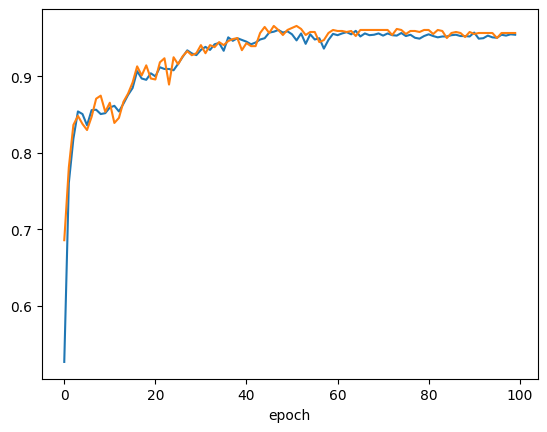

In [66]:
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

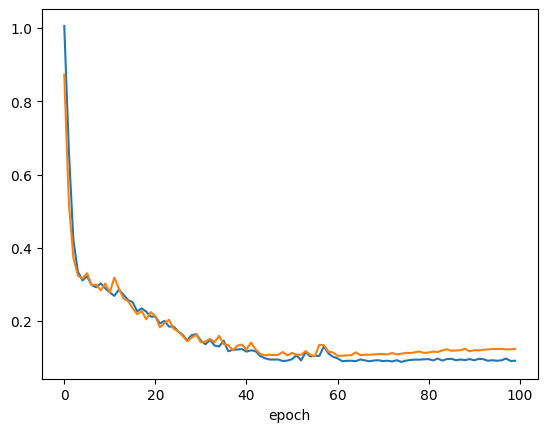

In [67]:
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.xlabel('epoch')

## 4.2 Model Evaluation

In [68]:
best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, label = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == label).sum().item()
    
    test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9657
